In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

import datetime

In [90]:
raw_dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [91]:
raw_dat.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,47,48,50,50,50,53,59,70,75
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,331,360,420,461,502,511,581,639,639,701
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,117,130,138,150,150,160,178,178,200
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,50,83,93,99,117,129,149,149,197


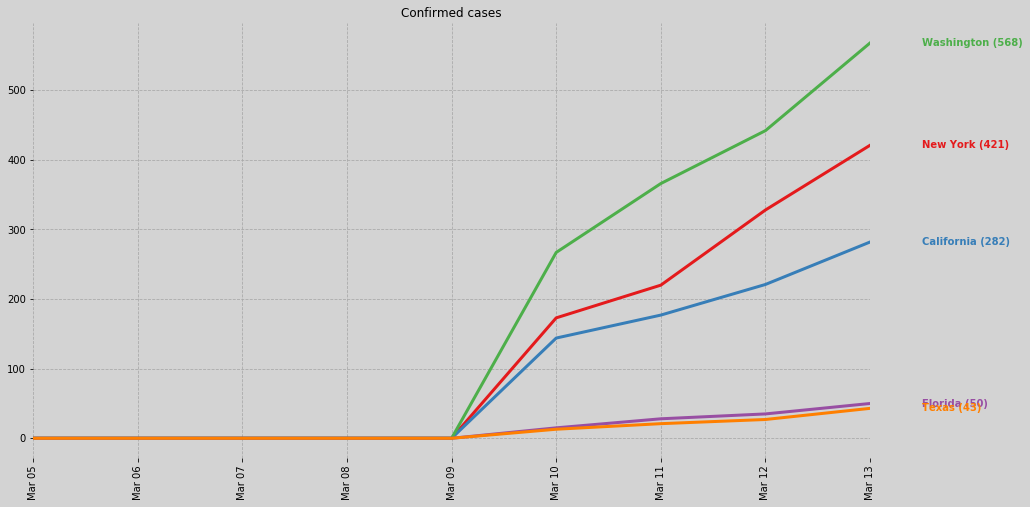

In [271]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

colors = cm.Set1
states = ['New York', 'California', 'Washington', 'Florida', 'Texas']
minx = 0

for n,s in enumerate(states):
    state = states[n]
    dat = raw_dat.loc[raw_dat['Province/State'] == state]
    
    y = list(dat.iloc[0,4:])
    x = [datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.columns[4:]]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
    
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(state, y[-1]), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
ax.set_xlim((x[minx-5], x[-1]))
ax.set_title('Confirmed cases')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')
    
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

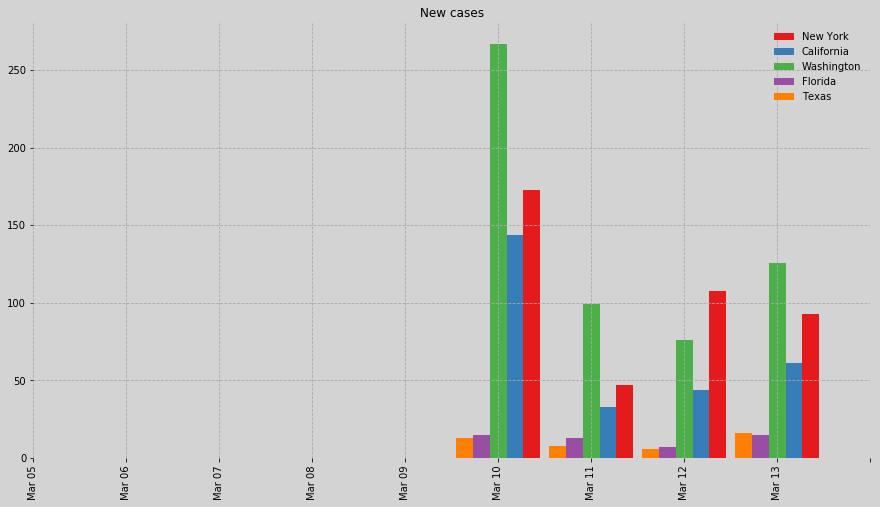

In [266]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

colors = cm.Set1
states = ['New York', 'California', 'Washington', 'Florida', 'Texas']
minx = 0
width = 0.9/len(states)

for n,s in enumerate(states):
    state = states[n]
    dat = raw_dat.loc[raw_dat['Province/State'] == state]
    
    y = np.diff(list(dat.iloc[0,4:]))
    #x = np.array([datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.columns[4:]][1:])
    x = np.arange(len(y))
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
    
    xpos = x + (len(states)/2 * width) - (n*width) - (width/2)
    ax.bar(x = xpos, height = y, width = width, color = colors(n), label = state)
    #ax.text(xpos[-1], 0, s = state, rotation = 90, color = 'black', ha = 'center', va = 'bottom', fontweight = 'bold', fontsize = 12)

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')
ax.legend(frameon = False)
ax.set_title('New cases')

x = [datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.columns[4:]][1:]
ax.set_xticks(np.arange(len(x)+10))
ax.set_xticklabels([c.strftime('%b %d') for c in x])
ax.set_xlim(max(minx-5,0), len(x))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
#ax.xaxis.set_major_formatter(xfmt)

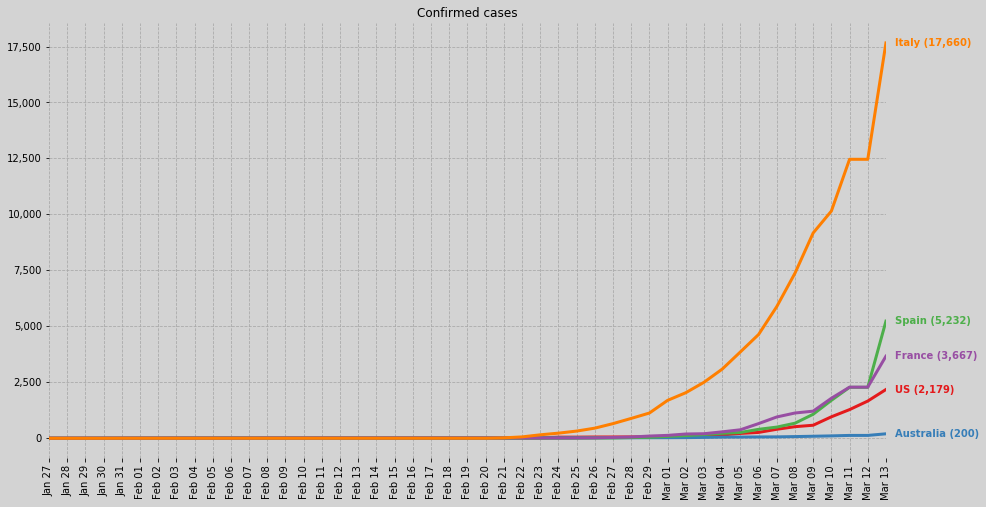

In [270]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

colors = cm.Set1
countries = ['US', 'Australia', 'Spain', 'France', 'Italy']
minx = 0

for n,s in enumerate(countries):
    country = countries[n]
    dat = raw_dat.loc[raw_dat['Country/Region'] == country]
    dat = dat.iloc[:,4:].sum(axis = 0)
    
    y = list(dat)
    x = [datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
        
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1:][0], '{} ({:,.0f})'.format(country, y[-1:][0]), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
ax.set_xlim((x[max(minx-5, 0)], x[-1]))
ax.set_title('Confirmed cases')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

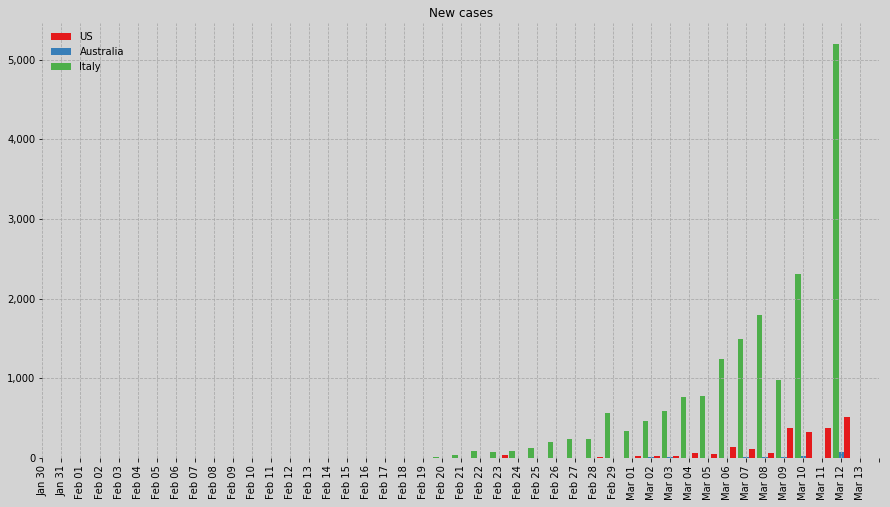

In [269]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

colors = cm.Set1
countries = ['US', 'Australia', 'Italy']
minx = 0
width = 0.9/len(countries)

for n,s in enumerate(countries):
    country = countries[n]
    dat = raw_dat.loc[raw_dat['Country/Region'] == country]
    dat = dat.iloc[:,4:].sum(axis = 0)
    
    y = np.diff(list(dat))
    #x = np.array([datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.columns[4:]][1:])
    x = np.arange(len(y))
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
    
    ax.bar(x = x + (len(countries)/2 * width) - (n*width) - (width/2), height = y, width = width, color = colors(n), label = country)
    #ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(state, y[-1]), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')
ax.legend(frameon = False)
ax.set_title('New cases')

x = [datetime.datetime.strptime(c, '%m/%d/%y') for c in dat.index]
ax.set_xticks(np.arange(len(x)+10))
ax.set_xticklabels([c.strftime('%b %d') for c in x])
ax.set_xlim(max(minx,0), len(x))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
#ax.xaxis.set_major_formatter(xfmt)